In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for logistic link

from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood


In [30]:
from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

class NegativeBinomialLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()        
        
        self.raw_r = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        r_constraint = Positive()
        self.register_constraint("raw_r", r_constraint)

        self.raw_mu = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        mu_constraint = Positive()
        self.register_constraint("raw_mu", mu_constraint)

    @property
    def mu(self) -> Tensor:
        return self.raw_mu_constraint.transform(self.raw_mu)

    @mu.setter
    def mu(self, value: Tensor) -> None:
        self._set_mu(value)
        
    def _set_mu(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_mu)
        self.initialize(raw_mu=self.raw_mu_constraint.inverse_transform(value))

    @property
    def r(self) -> Tensor:
        return self.raw_r_constraint.transform(self.raw_r)

    @r.setter
    def r(self, value: Tensor) -> None:
        self._set_r(value)
        
    def _set_r(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_r)
        self.initialize(raw_r=self.raw_r_constraint.inverse_transform(value))
        
    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.Poisson:
        mu = torch.exp(function_samples) #* self.mu
        probs = self.r / (mu + self.r)
        return base_distributions.NegativeBinomial(total_count = self.r, probs=probs)

In [50]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution, MeanFieldVariationalDistribution
from gpytorch.variational import VariationalStrategy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

N = 500
r = 1.5
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
mu = torch.exp(X)
probs = r / (mu + r)
y = base_distributions.NegativeBinomial(total_count = r, probs=probs).sample().double().cuda().flatten()

In [51]:
import math

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, feature_extractor):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.LinearKernel(),
        ) 
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

M = 100
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, feature_extractor=None).double()
likelihood = NegativeBinomialLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
#model.covar_module.base_kernel.initialize(lengthscale=5)
likelihood.train()
likelihood.initialize(r=1.5)

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 1000
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

100
2.13699523793579
200
2.1369704587359784
300
2.136944830717159
400
2.136919853929528
500
2.1368961638841295
600
2.1368740302575047
700
2.136853540886585
800
2.1368346868840424
900
2.1368174072085604
1000
2.1368016136639607


In [52]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

<Axes: xlabel='X1', ylabel='y'>

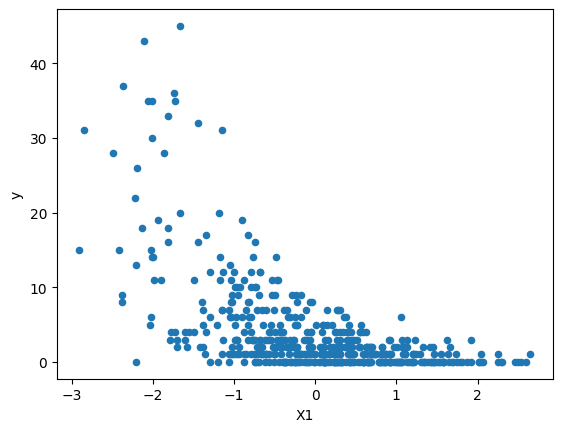

In [53]:
results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

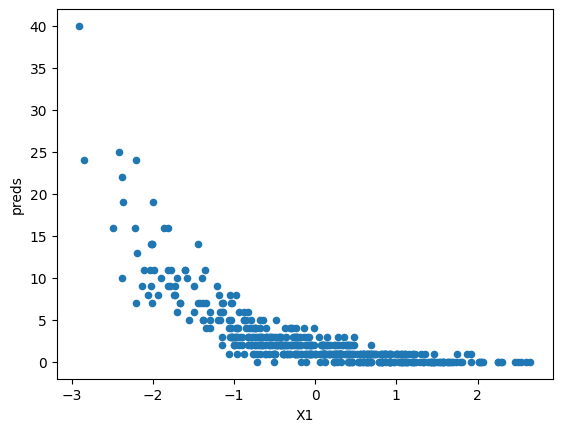

In [54]:
results_df.plot.scatter("X1", "preds")

In [133]:
N = 1000
r = 1
pi=0.35
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
mu = torch.exp(X)
probs = r / (mu + r)
y = base_distributions.ZeroInflatedNegativeBinomial(
    total_count = r, probs=probs, gate=torch.tensor([pi]).double().cuda()
).sample().double().cuda().flatten()

In [143]:
from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

class ZeroInflatedNegativeBinomialLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()        
        
        self.raw_r = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        r_constraint = Positive()
        self.register_constraint("raw_r", r_constraint)

        self.raw_mu = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        mu_constraint = Positive()
        self.register_constraint("raw_mu", mu_constraint)

        self.raw_pi = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        pi_constraint = Interval(0, 1)
        self.register_constraint("raw_pi", pi_constraint)

    @property
    def mu(self) -> Tensor:
        return self.raw_mu_constraint.transform(self.raw_mu)

    @mu.setter
    def mu(self, value: Tensor) -> None:
        self._set_mu(value)
        
    def _set_mu(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_mu)
        self.initialize(raw_mu=self.raw_mu_constraint.inverse_transform(value))

    @property
    def r(self) -> Tensor:
        return self.raw_r_constraint.transform(self.raw_r)

    @r.setter
    def r(self, value: Tensor) -> None:
        self._set_r(value)
        
    def _set_r(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_r)
        self.initialize(raw_r=self.raw_r_constraint.inverse_transform(value))

    @property
    def pi(self) -> Tensor:
        return self.raw_pi_constraint.transform(self.raw_pi)
        
    @pi.setter
    def pi(self, value: Tensor) -> None:
        self._set_pi(value)

    def _set_pi(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_pi)
        self.initialize(raw_pi=self.raw_pi_constraint.inverse_transform(value))
        
    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.Poisson:
        mu = torch.exp(function_samples) #* self.mu
        probs = self.r / (mu + self.r)
        pi = self.pi

        return base_distributions.ZeroInflatedNegativeBinomial(total_count = self.r, probs=probs, gate=pi)

In [156]:
import math

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, feature_extractor):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.LinearKernel(),
        ) 
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

M = 300
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, feature_extractor=None).double()
likelihood = ZeroInflatedNegativeBinomialLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
#model.covar_module.base_kernel.initialize(lengthscale=5)
likelihood.train()
likelihood.initialize(r=r, pi=pi)

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 300
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

30
1.120009747140143
60
1.1193212065549165
90
1.1192976401527635
120
1.1192873229745275
150
1.1192781201811177
180
1.1192688572682565
210
1.1192597701764533
240
1.1192509135025126
270
1.11924231905115
300
1.119234010389424


In [157]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

<Axes: xlabel='X1', ylabel='y'>

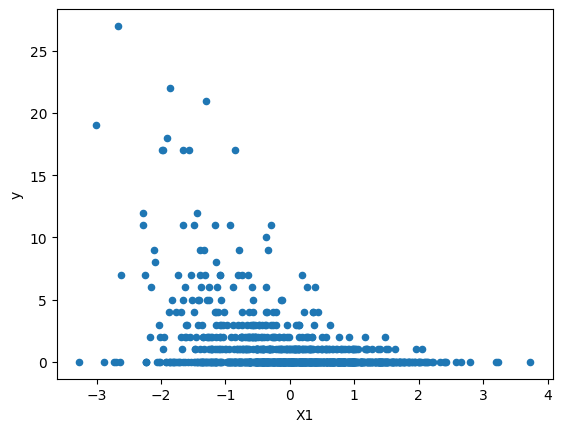

In [158]:
results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

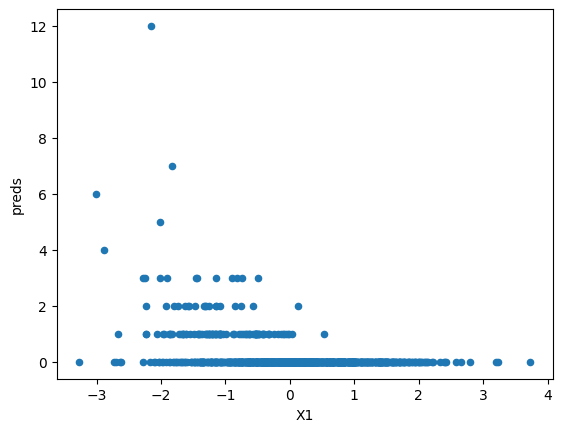

In [159]:
results_df.plot.scatter("X1", "preds")